# DS4G : Environmental Insights Explorer
# Exploring Alternatives for Emission Factor Calculations
# (Domain - Environment) (Analytics Prediction)

## The entire solution is divided into following notebooks

####1.   [DS4G Environmental Insights Explorer - introduction.(Part 1)](https://www.kaggle.com/meenakshiramaswamy/ds4g-eie-no2emission-earthenginereading)


####2.   [Exploration on data points, detailed analysis and correlation.(Part 2)](https://www.kaggle.com/meenakshiramaswamy/ds4g-eie-no2emission-eda/)

####3.   [Emission factor calculation and predictive model building.(Part 3)](https://www.kaggle.com/meenakshiramaswamy/ds4g-eie-no2emission-calcef-buildmodel/) 



#### [Part 2 - Exploration of Data points and analysis] is subdivided into following topics


*   Loading the necessary libraries 
*   Utility Functions
*   Reading the global power plant data
*   Calculate the input energy required for the powerplants
*   Convert the longitude, latitude into geometry points
*   Organize the image data into datasets
*   Find the co-relation between S5P, GFS and GLDAS images, influencing parameters on no2 density  




 pr = ee.Geometry.Polygon(
        [[[-67.32297404549217, 18.563112930177304],
          [-67.32297404549217, 17.903121359128956],
          [-65.19437297127342, 17.903121359128956],
          [-65.19437297127342, 18.563112930177304]]], null, false);

### Import all packages and dataset

#### Tifffile:  used to read the GeoTIFF files of satellite imagery and convert to python numpy arrays for further calculations

#### geopandas: The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely

#### rasterstats : Python module for summarizing geospatial raster datasets based on vector geometries. 

In [ ]:
### Folium is a Python Library that can allow us to visualize spatial data  Manipulate your data in Python, then visualize it in a Leaflet map via Folium ...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m

from datetime import datetime

import os
import glob

import rasterio as rio
import folium 

import geopandas
import tifffile as tiff
from folium import plugins
from shapely.geometry import Point
import rasterstats
from rasterstats import zonal_stats, point_query

In [ ]:
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
import warnings
warnings.filterwarnings('ignore')


In [ ]:
#Required only for Colab and Jypter NB
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px
configure_plotly_browser_state()

## Utility functions

In [ ]:
def plot_points_on_map(dataframe,latitude_value,longitude_value,zoom):
    #df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    fuelColor = {'Coal': 'darkred',
                 'Oil': 'black',
                 'Gas': 'lightgray',
                 'Hydro': 'lightblue',
                 'Solar': 'orange',
                 'Wind': 'green'
                }
    Map = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,dataframe.shape[0]):
        fuel = dataframe['primary_fuel'][i]
        lat = dataframe['latitude'][i]
        lon = dataframe['longitude'][i]
        name = dataframe['name'][i]
        #data = dataframe[i]
        popup = "{}, geolocation : [{},{}], {} ".format(fuel,lat, lon, name)
        #popup = pd.DataFrame(data).to_html()
        color = fuelColor[fuel]
        folium.Marker([lat,lon],
                      popup=popup,
                      icon=folium.Icon(color=color, icon_color='white', icon='bolt', prefix='fa')
                     ).add_to(Map)  
    

    return Map

    

In [ ]:
def overlay_image_on_puerto_rico(file_name,band_layer,lat,lon,zoom):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=zoom)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

def split_column_into_new_columns(dataframe,column_to_split,new_column_one,begin_column_one,end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe

In [ ]:
import json

def string_to_dict(dict_string):
    # Convert to proper json format (from here: https://stackoverflow.com/questions/39169718/convert-string-to-dict-then-access-keyvalues-how-to-access-data-in-a-class)
    dict_string = dict_string.replace("'", '"').replace('u"', '"')
    return json.loads(dict_string)['coordinates']



### We have been provided with the geographic boundary of Puerto Rico to calculate the emission factor from power plants

## Read the power plant data

In [ ]:
#for kaggle
power_plants = pd.read_csv('/kaggle/input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')
data_path = '/kaggle/input/ds4g-environmental-insights-explorer'
# For colab
#data_path = '/content/drive/My Drive/Kaggle-DS4G'
#power_plants = pd.read_csv(data_path+'/eie_data/gppd/gppd_120_pr.csv')

power_plants.head(5)


### Descriptive satistics on the datafram shows the NaN and missing values in categorical and numerical columns

In [ ]:
power_plants.describe (include = 'all')

Arrangement of Coordinates

In [ ]:
power_plants = split_column_into_new_columns(power_plants,'.geo','latitude',50,66)
power_plants = split_column_into_new_columns(power_plants,'.geo','longitude',31,48)
power_plants['latitude'] = power_plants['latitude'].astype(float)
a = np.array(power_plants['latitude'].values.tolist()) # 18 instead of 8
power_plants['latitude'] = np.where(a < 10, a+10, a).tolist() 
power_plants['longitude'] = power_plants['longitude'].astype(float)
power_plants['coord'] = power_plants['.geo'].apply(string_to_dict)
#power_plants.head()

**The dataset gppd_120_pr.csv contains 24 columns, we include only those are required as of now**

In [ ]:
power_plants_df = power_plants[['capacity_mw', 
                               'commissioning_year', 
                               'country', 
                               'estimated_generation_gwh', 
                               'source', 'name', 
                               'owner', 'primary_fuel','latitude','longitude','wepp_id','coord']]

In [ ]:
plt.figure(figsize=(15,17))
power_plants_df.groupby(['estimated_generation_gwh','primary_fuel']).sum()['capacity_mw'].plot(kind='bar')
plt.ylabel('capacity_mw');
plt.title('Fossil power plants grouped by power generation , fuel type');

In [ ]:
plt.figure(figsize=(15,15))
sns.barplot(x='capacity_mw', y='estimated_generation_gwh', hue='primary_fuel', data=  power_plants_df[power_plants_df['primary_fuel'].isin(['Coal','Oil','Gas'])])
#plt.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.ylabel('Estimated Generation')
plt.title('Capacity Vs Estimated Generation of fossil power plants');

In [ ]:

power_plants_df_fueltype = power_plants.groupby(['primary_fuel']).agg({'capacity_mw':'sum',
                                                                      'estimated_generation_gwh':'sum'}).reset_index()
power_plants_df_fueltype


**** Some power plants are in same location but fueled by either fuel oil or gas, Like Aguirre has both Gas and Oil plants

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Fuel Generation % from various type of power plants")
colors = ['g', 'orange', 'pink', 'c', 'm', 'y']
power_plants_df['primary_fuel'].value_counts().plot(kind='pie', colors=colors, 
 autopct='%1.1f%%',
counterclock=False, shadow=True)

In [ ]:
%matplotlib inline 

fig, ax = plt.subplots(figsize=[8,6])
plt.title ('Various Power Plants Capacity (in MW)')
plt.xlabel('Fuel Type')
plt.ylabel('Capacity mw');
ax.bar(power_plants_df_fueltype['primary_fuel'], power_plants_df_fueltype['capacity_mw'], color='YGR')

In [ ]:
power_plants['primary_fuel'].value_counts()

In [ ]:
### Using Geopandas we convert the coordinates into geometry and plot them in the map
'''
pp_gdf = geopandas.GeoDataFrame(
    power_plants_df, geometry=geopandas.points_from_xy(power_plants_df.longitude, power_plants_df.latitude))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to Puerto Rica.
ax = world[world.continent == 'Puerto Rica'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
pp_gdf.plot(ax=ax, color='magenta')

plt.show()
pp_gdf['name'] = pp_gdf['name'] + ':' + pp_gdf['primary_fuel']
'''
power_plants_fossil_df  = power_plants_df[power_plants_df['primary_fuel'].isin(['Coal','Oil','Gas'])]

#### The dataset contains both fossil and renewable powerplants. We split them into two datasets fossil and green plants

#### Source : Google 
#### Typical thermal efficiency for utility-scale electrical generators is around 37% for coal and oil-fired plants, and 56 – 60% (LEV) for combined-cycle gas-fired plants. Plants designed to achieve peak efficiency while operating at capacity will be less efficient when operating off-design (i.e. temperatures too low.)

#### Our PP dataset has only one Coal plant , A E S Corp located at the southern part of the country. The conventional steam coal is used (as per eie.gov), we define the efficiency of the different fuel type PP as per (https://www.eia.gov/electricity/annualhtml/epa_08_01.html
#### the average heating rate of coal for year 2018 is 10481, so efficiency would be 3412/10481 = 32%
#### petroleum, natural gas are 11095 and 7821, hence effiency would be 30%, 43%  respectively

In [ ]:
def pp_efficiency(x,y):
    if x == 'Coal':
        y = 32
    elif x  == 'Oil':
        y = 30
    elif x == 'Gas' :
        y = 43
    else : #nuclear
        y = 32   
    return y

In [ ]:
power_plants_fossil_df['Efficiency_percent'] = ""
power_plants_fossil_df['Efficiency_percent'] = power_plants_fossil_df.apply(lambda x: pp_efficiency(x.primary_fuel, x.Efficiency_percent), axis=1)


#### We measure the input energy in terms of thermal units , Btu. In order to get the (output) , how much input energy is needed for the powerplant? We multiply estimated generated gwh by 1000000 to convert to kwh,
#### 1 kwh = 3412 Btu

In [ ]:
def input_Btu(x,y):
    if x == 'Coal':
        y = y * 1000000 * 10481 
    elif x  == 'Oil':
        y = y * 1000000 * 11095 
    elif x == 'Gas' :
        y = y * 1000000 * 7821 
    else : #nuclear
        y = y * 1000000 * 10455   
    return y

In [ ]:
# Reference https://www.eia.gov/tools/faqs/faq.php?id=107&t=3
#power_plants_fossil_df['input_energy_gwh'] = (power_plants_fossil_df['estimated_generation_gwh'] / (power_plants_fossil_df['Efficiency_percent']*100))
#power_plants_fossil_df['input_energy_Btu'] = power_plants_fossil_df['input_energy_gwh'] * 3412 * 1000000


In [ ]:
power_plants_fossil_df['input_energy_Btu'] = ""
power_plants_fossil_df['input_energy_Btu'] = power_plants_fossil_df.apply(lambda x: input_Btu(x.primary_fuel, x.estimated_generation_gwh), axis=1)



####  capacity utilization of a powerplant/day is nothing but (estimated_generation_gwh * 1000 (mwh) /(365 multiplied by 24))

*   Assuming on stream days as 365 days

In [ ]:
# Convert gwh into mwh, find the capacity utilization per day
power_plants_fossil_df['capacity_utilization'] = (power_plants_fossil_df ['estimated_generation_gwh']/ power_plants_fossil_df['capacity_mw']  * 1000 ) / (365*24)


1.   Organic nitrogen compounds are found in coal and oil in concentrations of 
a few tenths to a few percent by weight

2.   Bituminous coal contains 1–2 percent nitrogen, and United States crude oil approximately 0.05–0.5 percent nitrogen (Demski et al. 1973).

3.   Natural gas, while containing up to 4 percent nitrogen gas, does not contain any significant organic nitrogen (Perry et al. 1963). Because organic nitrogen compounds have relatively high molecular weights, they tend to be concentrated in the residual and heavy oil fractions during distillation.

4.   Nitrogen oxides are produced during combustion by the oxidation of organic nitrogen compounds in fossil fuels and by the thermal fixation of atmospheric nitrogen gas, N2.

Refer : https://www.nap.edu/read/10840/chapter/18#716

#### The emission factor of fossil fuels are measured in gms per mmBtu, So the conversion would be dividing the input energy in mmBtu by 1000000 and multiplying the emissions per mmBtu according to each fuel type

Refer : https://www.epa.gov/sites/production/files/2015-07/documents/emission-factors_2014.pdf

In [ ]:
# no2 emission in gms per input energy in Btu for powerplant , convert into mmBtu, then apply the emission / gm value
def nox_emission_gms(x,y):
    if x == 'Coal':
        y = ( y / 1000000 ) * 1.6
    elif x  == 'Oil':
        y = ( y / 1000000 ) * 0.6
    elif x == 'Gas':
        y = ( y / 1000000 ) * 0.1
    return y


In [ ]:
power_plants_fossil_df['no2_Emission_for_input_Btu_in_gms'] = ""
power_plants_fossil_df['no2_Emission_for_input_Btu_in_gms'] = power_plants_fossil_df.apply(lambda x: nox_emission_gms(x.primary_fuel, x.input_energy_Btu), axis=1)

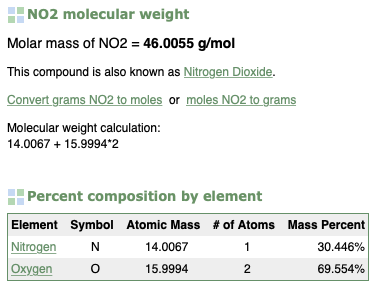

### No2 / mols is 46.0055 during conversion from grams to moles

In [ ]:
power_plants_fossil_df['no2_emission_in_tons'] = power_plants_fossil_df['no2_Emission_for_input_Btu_in_gms'] / 1000000
power_plants_fossil_df['no2_emission_in_mols'] = power_plants_fossil_df['no2_Emission_for_input_Btu_in_gms'] / 46.0055

In [ ]:
power_plants_fossil_df[['capacity_mw','estimated_generation_gwh','name','primary_fuel','input_energy_Btu',#'capacity_utilization',
                        'no2_Emission_for_input_Btu_in_gms','no2_emission_in_tons', 'no2_emission_in_mols']]

In [ ]:
power_plants_fossil_df.info()

In [ ]:
'''
plt.figure(figsize=(25,15))
sns.barplot(x='no2_in_mols', y='no2_Emission_for_input_Btu_in_gms', hue='primary_fuel', data=power_plants_fossil_df[power_plants_fossil_df['primary_fuel'].isin(['Coal','Oil','Gas'])])
#plt.set_xticklabels(a.get_xticklabels(), rotation=45)
plt.ylabel('Estimated Generation')
plt.title('no2_in_mols Vs no2_Emission_for_input_Btu_in_gms of fossil power plants');
'''

#### Gas power plants are less pollutants compared to oil and Coal plants

In [ ]:
power_plants_renew_df  = power_plants_df[power_plants_df['primary_fuel'].isin(['Wind','Hydro','Solar'])]
power_plants_renew_df.head()

In [ ]:
power_plants_df.to_csv('power_plants.csv')
power_plants_fossil_df.to_csv('fossil.csv')
power_plants_renew_df.to_csv('renew.csv')
#pp_gdf.to_csv('pp_gdf.csv')

https://www.kaggle.com/vpatricio/ds4g-where-does-the-no2-come-from

### For fiscal year 2019, 
### petroleum fueled 40% of Puerto Rico’s total electricity generation 
### natural gas accounted for 39%. 
### Coal continued to fuel 18% of generation, 
### while renewables supplied 2.3%.

## 329 Kwh /kg of coal. 1MWH = 1000 Kwh, =1000 ÷0.329 =3039.5kgs or 3040kgs of coal is required for 1MWH generation of electrical power.

In [ ]:
power_plants_fossil_df[power_plants_fossil_df['primary_fuel'] == ('Coal')]

### Total Capacity of fossil power plants
#### Oil, Gas, Coal 

In [ ]:

print ('Oil: ', power_plants_fossil_df.loc[power_plants_fossil_df.primary_fuel=='Oil','capacity_mw'].sum() )
print ('Gas :',power_plants_fossil_df.loc[power_plants_fossil_df.primary_fuel=='Gas','capacity_mw'].sum() )
print ('Coal:',power_plants_fossil_df.loc[power_plants_fossil_df.primary_fuel=='Coal','capacity_mw'].sum() )

###  Organize the data from the image files

#### Need to extract the date details from the file names, GFS , GLDAS contains single date with time, whereas s5p contains both starting and ending datetime

In [ ]:
def convert_df( dff, j):
    name, ext = dff['filename'][j].split('.')
    #print (name, ext)
    df_name = name[0:3]
    split_str = name.split('_')
    
    if df_name in 'gld' :
        dff['dataset'][j] = split_str[0]
        dff['date_from'][j] = split_str[1]
        dff['time_f'][j] = split_str[2]
    elif df_name in 'gfs':
        dff['dataset'][j] = split_str[0]
        dff['date_from'][j] = split_str[1][:-2]
        dff['time_f'][j] = split_str[1][8:]+'00'
    elif df_name in 's5p':
        dff['dataset'][j] = split_str[0]+'_'+split_str[1]
        dff['date_from'][j] = split_str[2][:8]
        dff['date_to'][j] = split_str[3][:8]
        dff['time_f'][j] = split_str[2][9:]
        dff['time_t'][j] = split_str[3][9:]
        #dff['no2_mean'] = np.mean(tiff.imread(image)[:, :, 0 : 4])

In [ ]:
gldas_files = os.listdir(data_path + '/eie_data/gldas')
df_gldas = pd.DataFrame(gldas_files)
df_gldas.rename(columns={0:'filename'}, inplace=True)
df_gldas['dataset'] = ""
df_gldas['date_from']=""
df_gldas['time_f']=""

for i in range(df_gldas.shape[0]):
    convert_df(df_gldas, i)
df_gldas.head()   

In [ ]:
gfs_files = os.listdir(data_path + '/eie_data/gfs')
df_gfs = pd.DataFrame(gfs_files)
df_gfs.rename(columns={0:'filename'}, inplace=True)
df_gfs['dataset'] = ""
df_gfs['date_from']=""
df_gfs['time_f']=""

for i in range(df_gfs.shape[0]):
    convert_df(df_gfs, i)
df_gfs.head(5)  

### Sentinel-5P OFFL NO2: Offline Nitrogen Dioxide

In [ ]:
image = data_path + '/eie_data/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'
im = rio.open(image)
im.descriptions
im.dataset_mask()
im.units

### We can find the coordinates for individual positions within each image by running the following code snippet:

In [ ]:
def preview_meta_data(file_name):
    with rio.open(file_name) as img_filename:
        print('Bounding Box:',img_filename.bounds)
        print('\nCoordinates of Top Left Corner: ',img_filename.transform * (0,0))
        print('\nCoordinates of Bottom Right Corner: ',img_filename.transform * (img_filename.width,img_filename.height))

In [ ]:
preview_meta_data(image)

In [ ]:
s5p_files = os.listdir(data_path + '/eie_data/s5p_no2')
df_s5p_no2 = pd.DataFrame(s5p_files)
df_s5p_no2.rename(columns={0:'filename'}, inplace=True)
df_s5p_no2['dataset'] = ""
df_s5p_no2['date_from']=""
df_s5p_no2['date_to']=""
df_s5p_no2['time_f']=""
df_s5p_no2['time_t']=""

for i in range(df_s5p_no2.shape[0]):
    convert_df(df_s5p_no2, i)
    #print (df_s5p_no2)
df_s5p_no2.head(5)  


In [ ]:
#print (os.listdir(data_path + '/eie_data/s5p_no2'))

df_s5p_mean_no2 = pd.DataFrame(s5p_files)
df_s5p_mean_no2.rename(columns={0:'filename'}, inplace=True)
df_s5p_mean_no2['no2_mean'] = ""
df_s5p_mean_no2['NO2_col_density'] = ""
df_s5p_mean_no2['tropospheric_NO2'] = ""
df_s5p_mean_no2['stratospheric_NO2'] = ""
df_s5p_mean_no2['NO2_slant_col_density'] = ""
df_s5p_mean_no2['tropopause_pressure_mean'] = ""
df_s5p_mean_no2['aai_mean'] = ""
df_s5p_mean_no2['cloud_fraction_mean'] = ""


In [ ]:
s5p_no2_path = glob.glob(data_path+'/eie_data/s5p_no2/*')
for (i, image) in enumerate(s5p_no2_path):
    #df_s5p_mean_no2['img_no2_data'][i] = tiff.imread(image)[:, :, 0 : 4] # first 4 bands
    #df_s5p_mean_no2['img_data'][i] = tiff.imread(image)[:, :, 5 : 8] # all bands
    img = tiff.imread(image)
    #print (img)
    df_s5p_mean_no2['no2_mean'][i] = np.nanmean(img[:, :, 0 : 4])
    df_s5p_mean_no2['NO2_col_density'][i] = img[:, :, 0 ]
    df_s5p_mean_no2['tropospheric_NO2'][i] = np.nanmean(img[:, :, 1 ])
    df_s5p_mean_no2['stratospheric_NO2'][i] = img[:, :, 2 ]
    df_s5p_mean_no2['NO2_slant_col_density'][i] = img[:, :, 3 ]
    df_s5p_mean_no2['tropopause_pressure_mean'] [i] = np.nanmean(img[:, : , 4])
    df_s5p_mean_no2['aai_mean'][i] = np.nanmean(img[:, :, 5 ])    
    df_s5p_mean_no2['cloud_fraction_mean'][i] = np.nanmean(img[:,:,6])
    #print ("{:.8f}".format(x))


In [ ]:
print (df_s5p_mean_no2['NO2_col_density'][0])
print (np.flip(df_s5p_mean_no2['NO2_col_density'][0]))

In [ ]:
df_s5p_no2 = pd.merge(df_s5p_no2, df_s5p_mean_no2, left_on='filename', right_on='filename')

df_s5p_no2['filename']= df_s5p_no2['filename'].astype(str)
df_s5p_no2['dataset'] = df_s5p_no2['dataset'].astype(str)
df_s5p_no2['date_from'] = pd.to_datetime(df_s5p_no2['date_from'])
df_s5p_no2['date_to'] = pd.to_datetime(df_s5p_no2['date_to'])

df_s5p_no2['tropopause_pressure_mean'] = df_s5p_no2['tropopause_pressure_mean'].fillna("")
df_s5p_no2['aai_mean'] = df_s5p_no2['aai_mean'].fillna("")
df_s5p_no2['cloud_fraction_mean'] = df_s5p_no2['cloud_fraction_mean'].fillna("")
df_s5p_no2['no2_mean'] = df_s5p_no2['no2_mean'].fillna("")
#df_s5p_no2['tropospheric_NO2'] = df_s5p_no2['tropospheric_NO2'].fillna("")

df_s5p_no2.sort_values('date_from', inplace = True)
df_s5p_no2.reset_index(drop = True, inplace = True)

**Check for Not Null values**

In [ ]:

s5p_no2_df = df_s5p_no2[['filename','dataset','date_from','date_to','no2_mean','tropospheric_NO2','tropopause_pressure_mean','aai_mean','cloud_fraction_mean']].copy()

sentinel_no_nan_df = s5p_no2_df[s5p_no2_df['no2_mean'] != ""]

sentinel_nan_df = s5p_no2_df[s5p_no2_df['no2_mean'] == ""]

In [ ]:
def line_plot(df, x, y, title, width, height, col):
    trace = go.Scatter(
        x = df[x],
        y = df[y],
        mode='lines+markers',
        name=title,
        marker = dict(
            color = col, 
        ), 
    )
    
    
    layout = go.Layout(
        title = go.layout.Title(
            text = title,
            x = 0.05
        ),
        font = dict(size = 10),
        width = width,
        height = height,
    )
    
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig, filename = 'line_plot')
    

In [ ]:
configure_plotly_browser_state() # To be used in the cell when using Colab or Jypter NB
line_plot(sentinel_no_nan_df, 'date_from', 'tropospheric_NO2', 'NO2 emission - tropospheric_NO2 ', 1000, 600, 'lightblue')

line_plot(sentinel_no_nan_df, 'date_from', 'no2_mean', 'NO2 emission - all NO2 ', 1000, 600, 'purple')

In [ ]:
configure_plotly_browser_state() # To be used in the cell when using Colab or Jypter NB

#line_plot(df_s5p_test, 'start_date', 'no2_mean', 'NO2 emission - mean excluding NaN', 1000, 500)
    
line_plot(sentinel_no_nan_df, 'date_from', 'aai_mean', 'NO2 emission - AAI ', 1000, 600, 'orange')

#line_plot(sentinel_no_nan_df, 'date_from', 'cloud_fraction_mean', 'NO2 emission - Cloud fraction excluding NaN', 1000, 600, 'maroon')

line_plot(sentinel_no_nan_df, 'date_from', 'tropopause_pressure_mean', 'NO2 emission - tropopause pressure ', 1000, 600, 'green')



### More Q&A pls refer the below link 
https://www.kaggle.com/c/ds4g-environmental-insights-explorer/discussion/129991

### GFS: Global Forecast System 384-Hour Predicted Atmosphere Data

In [ ]:
image = data_path+'/eie_data/gfs/gfs_2018070306.tif'
im = rio.open(image)
im.descriptions
im.dataset_mask()
im.units
im.bounds

In [ ]:
preview_meta_data(data_path+'/eie_data/gfs/gfs_2018070306.tif')

### Lets explore the gfs image band details

In [ ]:
df_gfs_data = pd.DataFrame(gfs_files)
df_gfs_data.rename(columns={0:'filename'}, inplace=True)

df_gfs_data['temp_2m_above_ground_mean']      = ""
df_gfs_data['sp_humidity_2m_above_ground_mean'] = ""
df_gfs_data['rh_2m_above_ground_mean']       = ""
df_gfs_data['u_wind_10m_above_ground_mean']     = ""
df_gfs_data['v_wind_10m_above_ground_mean']   = ""
df_gfs_data['wind_velocity'] = ""
df_gfs_data['tot_percip_surface_mean']         = ""

In [ ]:
gfs_path = glob.glob(data_path+'/eie_data/gfs/*')
#gfs_path
for i, image in enumerate(gfs_path):
    img = tiff.imread(image)
    #df_gfs_data['temperature_2m_above_ground'][i]          = img[:, :, 0 ]
    #df_gfs_data['specific_humidity_2m_above_ground'][i]    = img[:, :, 1 ]
    #df_gfs_data['relative_humidity_2m_above_ground'][i]    = img[:, :, 2 ]
    #df_gfs_data['u_component_of_wind_10m_above_ground'][i] = img[:, :, 3 ]
    #df_gfs_data['v_component_of_wind_10m_above_ground'][i] = img[:, :, 4]  
    #df_gfs_data['total_precipitation_surface'][i]          = img[:, :, 5] 
    df_gfs_data['temp_2m_above_ground_mean'][i]        = np.nanmean(img[:, :, 0 ])
    df_gfs_data['sp_humidity_2m_above_ground_mean'][i] = np.nanmean(img[:, :, 1 ])
    df_gfs_data['rh_2m_above_ground_mean'][i]          = np.nanmean(img[:, :, 2 ])
    u_val = np.nanmean(img[:, :, 3 ])
    v_val = np.nanmean(img[:, :, 4 ])
    df_gfs_data['u_wind_10m_above_ground_mean'][i]     = u_val
    df_gfs_data['v_wind_10m_above_ground_mean'][i]     = v_val 
    df_gfs_data['wind_velocity'][i] = m.sqrt ( m.pow(u_val,2 ) + m.pow(v_val, 2) ) 
    df_gfs_data['tot_percip_surface_mean'][i]          = np.nanmean(img[:, :, 5] )

In [ ]:
gfs_df = pd.merge(df_gfs, df_gfs_data, left_on='filename', right_on='filename')

gfs_df_copy = gfs_df[['filename','dataset','date_from','time_f','temp_2m_above_ground_mean','sp_humidity_2m_above_ground_mean',
                     'rh_2m_above_ground_mean','u_wind_10m_above_ground_mean','v_wind_10m_above_ground_mean', 'wind_velocity',
                     'tot_percip_surface_mean']].copy()

gfs_df_copy['filename']= gfs_df_copy['filename'].astype(str)
gfs_df_copy['dataset'] = gfs_df_copy['dataset'].astype(str)
gfs_df_copy['date_from'] = pd.to_datetime(gfs_df_copy['date_from'])
gfs_df_copy['time_f'] = gfs_df_copy['time_f'].astype(str)
gfs_df_copy['temp_2m_above_ground_mean'] = gfs_df_copy['temp_2m_above_ground_mean'].astype(float)
gfs_df_copy['sp_humidity_2m_above_ground_mean'] = gfs_df_copy['sp_humidity_2m_above_ground_mean'].astype(float)
gfs_df_copy['rh_2m_above_ground_mean'] = gfs_df_copy['rh_2m_above_ground_mean'].astype(float)
gfs_df_copy['u_wind_10m_above_ground_mean'] = gfs_df_copy['u_wind_10m_above_ground_mean'].astype(float)

gfs_df_copy['v_wind_10m_above_ground_mean'] = gfs_df_copy['v_wind_10m_above_ground_mean'].astype(float)
gfs_df_copy['wind_velocity'] = gfs_df_copy['wind_velocity'].astype(float)

gfs_df_copy.sort_values('date_from', inplace = True)
gfs_df_copy.reset_index(drop = True, inplace = True)

In [ ]:
configure_plotly_browser_state() # To be used in the cell when using Colab or Jypter NB

line_plot(gfs_df_copy, 'date_from', 'temp_2m_above_ground_mean', 'GFS-temp_2m_above_ground_mean', 1200, 600, 'indigo')

#line_plot(gfs_df_copy, 'date_from', 'sp_humidity_2m_above_ground_mean', 'GFS-sp_humidity_2m_above_ground_mean', 1200, 600, 'pink')

line_plot(gfs_df_copy, 'date_from', 'rh_2m_above_ground_mean', 'GFS-rh_2m_above_ground_mean', 1200, 600, 'aquamarine')


line_plot(gfs_df_copy, 'date_from', 'wind_velocity', 'GFS-wind-velocity', 1200, 600, 'orange')

line_plot(gfs_df_copy, 'date_from', 'tot_percip_surface_mean', 'GFS-tot_percip_surface_mean', 1200, 600, 'lightblue')

### gfs has no missing data. So we merge the sentinel df without nan values to gfs df to find the correlation between these two datasets

In [ ]:
no2_dfs_merge_df = pd.DataFrame()
no2_dfs_merge_df = pd.merge(gfs_df_copy, sentinel_no_nan_df, left_on='date_from', right_on='date_from')

no2_dfs_weather_df = no2_dfs_merge_df[['date_from','time_f','temp_2m_above_ground_mean','sp_humidity_2m_above_ground_mean',
                     'rh_2m_above_ground_mean','u_wind_10m_above_ground_mean','v_wind_10m_above_ground_mean','wind_velocity',
                     'tot_percip_surface_mean', 'tropospheric_NO2','aai_mean','tropopause_pressure_mean','cloud_fraction_mean', 'no2_mean']].copy()

#### GFS provides 4 readings i.e every 6 hours data

In [ ]:
no2_dfs_weather_df['temp_2m_above_ground_mean'] = no2_dfs_weather_df['temp_2m_above_ground_mean'].astype(float)
no2_dfs_weather_df['sp_humidity_2m_above_ground_mean'] = no2_dfs_weather_df['sp_humidity_2m_above_ground_mean'].astype(float)
no2_dfs_weather_df['rh_2m_above_ground_mean'] = no2_dfs_weather_df['rh_2m_above_ground_mean'].astype(float)
no2_dfs_weather_df['u_wind_10m_above_ground_mean'] = no2_dfs_weather_df['u_wind_10m_above_ground_mean'].astype(float)

no2_dfs_weather_df['v_wind_10m_above_ground_mean'] = no2_dfs_weather_df['v_wind_10m_above_ground_mean'].astype(float)
no2_dfs_weather_df['wind_velocity'] = no2_dfs_weather_df['wind_velocity'].astype(float)
no2_dfs_weather_df['tot_percip_surface_mean'] = no2_dfs_weather_df['tot_percip_surface_mean'].astype(float)
no2_dfs_weather_df['tropospheric_NO2'] = no2_dfs_weather_df['tropospheric_NO2'].astype(float)


In [ ]:
no2_dfs_weather_df['time_f'] = no2_dfs_weather_df['time_f'].astype(float)
no2_dfs_weather_df['temp_2m_above_ground_mean'] = no2_dfs_weather_df['temp_2m_above_ground_mean'].astype(float)
no2_dfs_weather_df['sp_humidity_2m_above_ground_mean'] = no2_dfs_weather_df['sp_humidity_2m_above_ground_mean'].astype(float)

no2_dfs_weather_df['rh_2m_above_ground_mean'] = no2_dfs_weather_df['rh_2m_above_ground_mean'].astype(float)
no2_dfs_weather_df['u_wind_10m_above_ground_mean'] = no2_dfs_weather_df['u_wind_10m_above_ground_mean'].astype(float)

no2_dfs_weather_df['v_wind_10m_above_ground_mean'] = no2_dfs_weather_df['v_wind_10m_above_ground_mean'].astype(float)
no2_dfs_weather_df['wind_velocity'] = no2_dfs_weather_df['wind_velocity'] .astype(float)
no2_dfs_weather_df['tot_percip_surface_mean'] = no2_dfs_weather_df['tot_percip_surface_mean'].astype(float)


no2_dfs_weather_df['aai_mean'] = no2_dfs_weather_df['aai_mean'].astype(float)
no2_dfs_weather_df['tropopause_pressure_mean'] = no2_dfs_weather_df['tropopause_pressure_mean'].astype(float)
no2_dfs_weather_df['cloud_fraction_mean'] = no2_dfs_weather_df['cloud_fraction_mean'].astype(float)
no2_dfs_weather_df['no2_mean'] = no2_dfs_weather_df['no2_mean'].astype(float)
no2_dfs_weather_df['tropospheric_NO2'] = no2_dfs_weather_df['tropospheric_NO2'].astype(float)


#### **However, the reaction of NO with tropospheric ambient concentrations of O3 (ozone) to form NO2 is rapid**.

#### To check the wind speed and direction in the noon and correlate with no2



In [ ]:
no2_dfs_weather_df[(no2_dfs_weather_df.time_f == 1200.0) & (no2_dfs_weather_df.date_from >= '2019-05-01') & (no2_dfs_weather_df.date_from <= '2019-05-10')]

### To check the wind speed and direction at midnight and correlate with no2

In [ ]:
no2_dfs_weather_df[(no2_dfs_weather_df.time_f == 0000.0) & (no2_dfs_weather_df.date_from >= '2019-05-01') & (no2_dfs_weather_df.date_from <= '2019-05-02')]

#### To check all the parameters affecting NO2 for couple of days

In [ ]:
no2_dfs_weather_df[ (no2_dfs_weather_df.date_from >= '2019-05-01') & (no2_dfs_weather_df.date_from <= '2019-05-02')]

In [ ]:
corr_weather_and_no2 = no2_dfs_weather_df.corr()

plt.figure(figsize=(20,13))
a = sns.heatmap(corr_weather_and_no2, annot = True, cmap = 'inferno')
a.Title = 'NO2 - Weather Data Correlation';
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=45)
plt.show()


#### NO2 is positively correlated with temparature 2m above ground, aerosol index , tropopause pressure and specific humidity, wind velocity

In [ ]:
sns.jointplot(x="tropospheric_NO2", y="sp_humidity_2m_above_ground_mean", data=no2_dfs_weather_df,kind = 'kde', color="purple")

### GLDAS-2.1: Global Land Data Assimilation System

In [ ]:
image = data_path + '/eie_data/gldas/gldas_20190528_0000.tif'
im = rio.open(image)
im.descriptions
im.count
im.tags(ns='IMAGE_STRUCTURE')

In [ ]:
preview_meta_data(image)

In [ ]:
df_gldas_data = pd.DataFrame(gldas_files)
df_gldas_data.rename(columns={0:'filename'}, inplace=True)

df_gldas_data['Qair_f_inst_mean'] = "" #Specific humidity
df_gldas_data['Rainf_f_tavg_mean']= "" #Rain
df_gldas_data['Tair_f_inst_mean'] = "" #Air temperature
df_gldas_data['Wind_f_inst_mean'] = "" #Wind Speed

In [ ]:
gldas_path = glob.glob(data_path+'/eie_data/gldas/*')
for i, image in enumerate(gldas_path):
    #df_gfs_data['no2_mean'][i] = np.average(tiff.imread(image)[:, :, 0 : 4])
    img = tiff.imread(image)
    #df_gldas_data['Qair_f_inst'][i] = img[:, :, 3 ]
    #df_gldas_data['Rainf_f_tavg'][i] = img[:, : , 7]
    #df_gldas_data['Tair_f_inst'][i] = img[:, :, 10 ]
    #df_gldas_data['Wind_f_inst'][i] = img[:, :, 11 ]
    df_gldas_data['Qair_f_inst_mean'][i] = np.nanmean(img[:, :, 3])  
    df_gldas_data['Rainf_f_tavg_mean'][i] = np.nanmean(img[:,:,7])
    df_gldas_data['Tair_f_inst_mean'][i] = np.nanmean(img[:, :, 10 ])
    df_gldas_data['Wind_f_inst_mean'][i] = np.nanmean(img[:, :, 11 ])

In [ ]:
df_gldas = pd.merge(df_gldas, df_gldas_data, left_on='filename', right_on='filename')

df_gldas['filename']= df_gldas['filename'].astype(str)
df_gldas['dataset'] = df_gldas['dataset'].astype(str)
df_gldas['date_from'] = pd.to_datetime(df_gldas['date_from'])
df_gldas['time_f'] = df_gldas['time_f'].astype(float)

df_gldas.sort_values('date_from', inplace = True)
df_gldas.reset_index(drop = True, inplace = True)

no2_gldas_merge_df = pd.DataFrame()

no2_gldas_merge_df = pd.merge(df_gldas, no2_dfs_weather_df, left_on= 'date_from', right_on = 'date_from', how = "inner")

no2_gldas_merge_df.set_index('date_from','time_f')

In [ ]:
no2_dfs_gldas_df = no2_gldas_merge_df[['date_from','time_f_x',#gldas time
                                       'time_f_y',#gfs time
                                       'temp_2m_above_ground_mean',
                                       'sp_humidity_2m_above_ground_mean',
                                         'rh_2m_above_ground_mean',
                                      # 'u_wind_10m_above_ground_mean','v_wind_10m_above_ground_mean',
                                       'wind_velocity',
                                         'tot_percip_surface_mean', 
                                       'aai_mean',
                                       'tropopause_pressure_mean',
                                       'cloud_fraction_mean', 
                                       'tropospheric_NO2',
                                       'no2_mean',
                                         'Rainf_f_tavg_mean',
                                       'Qair_f_inst_mean',
                                         'Tair_f_inst_mean',
                                       'Wind_f_inst_mean']].copy()


no2_dfs_gldas_df['Qair_f_inst_mean'] = no2_dfs_gldas_df['Qair_f_inst_mean'].astype(float)
no2_dfs_gldas_df['Rainf_f_tavg_mean'] = no2_dfs_gldas_df['Rainf_f_tavg_mean'].astype(float)
no2_dfs_gldas_df['Tair_f_inst_mean'] = no2_dfs_gldas_df['Tair_f_inst_mean'].astype(float)
no2_dfs_gldas_df['Wind_f_inst_mean'] = no2_dfs_gldas_df['Wind_f_inst_mean'].astype(float)
no2_dfs_gldas_df['time_f_x'] = no2_dfs_gldas_df['time_f_x'].astype(float)
no2_dfs_gldas_df['time_f_y'] = no2_dfs_gldas_df['time_f_y'].astype(float)

In [ ]:
#no2_dfs_gldas_df.info()
no2_dfs_gldas_df.to_csv('no2_dfs_gldas_df.csv')

In [ ]:
all_df_corr = no2_dfs_gldas_df.corr()

plt.figure(figsize=(20,16))
a = sns.heatmap(all_df_corr, annot = True, cmap = 'gist_earth')
a.Title = 'NO2 # Weather # Land Data Correlation';
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=45)
plt.show()

#### There is a positive corelation between tropospheric no2 and 'Tair_f_inst_mean','Wind_f_inst_mean', 'sp_humidity_2m_above_ground_mean', wind velocity, temp_2m_above_ground_mean and tropopause pressure

#### GLDAS records data every 3 hours, so we have  8 image readings per day

#### Lets choose some randam date, take the data at midnight and 12 noon (30-May-2019)

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2019-05-30') & (no2_dfs_gldas_df.time_f_x == 0.0) & (no2_dfs_gldas_df.time_f_y == 0.0)]

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2019-05-30') & (no2_dfs_gldas_df.time_f_x == 1200.0) & (no2_dfs_gldas_df.time_f_y == 1200.0)]

#### There is no significant impact in the tropospheric no2 density, lets have a look at 6 am data

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2019-05-30') & (no2_dfs_gldas_df.time_f_x == 600.0) & (no2_dfs_gldas_df.time_f_y == 600.0)]

tropospheric_NO2 value 0.00001

Lets analyse another data for the month of december 2018 (28-Dec-2018)

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2018-12-28') & (no2_dfs_gldas_df.time_f_x == 0.0) & (no2_dfs_gldas_df.time_f_y == 0.0)]

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2018-12-28') & (no2_dfs_gldas_df.time_f_x == 1200.0) & (no2_dfs_gldas_df.time_f_y == 1200.0)]

In [ ]:
no2_dfs_gldas_df[(no2_dfs_gldas_df.date_from == '2018-12-28') & (no2_dfs_gldas_df.time_f_x == 600.0) & (no2_dfs_gldas_df.time_f_y == 600.0)]

**There is decrease on trophospheric no2 and all-no2-mean value due to wind ( 28-Dec-2018), so this confirms that no2 density is positively correlated to wind speed.
tropospheric_NO2 value 0.000009

In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(no2_dfs_gldas_df.tropospheric_NO2)

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="tropospheric_NO2", y="wind_velocity",data=no2_dfs_gldas_df, hue="tropospheric_NO2"  )

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x="tropospheric_NO2", y="tot_percip_surface_mean",data=no2_dfs_gldas_df, hue="tropospheric_NO2" ,color = 'orange' )

In [ ]:
#plt.figure(figsize=(20, 10))
#sns.jointplot(x="tropospheric_NO2", y="v_wind_10m_above_ground_mean", data=no2_dfs_gldas_df,  kind="reg", color = 'green')

In [ ]:
plt.figure(figsize=(20, 10))
sns.jointplot(x="tropospheric_NO2", y="Wind_f_inst_mean", data=no2_dfs_gldas_df,kind = 'kde', color="maroon")

In [ ]:
plt.figure(figsize=(20, 10))
sns.jointplot(x="tropospheric_NO2", y="temp_2m_above_ground_mean", data=no2_dfs_gldas_df ,kind="hex")


In [ ]:
plt.figure(figsize=(20, 10))
sns.jointplot(x="tropospheric_NO2", y="Rainf_f_tavg_mean", data=no2_dfs_gldas_df,kind = 'kde', color="lightgreen")

#### Next kernel discusses the emission factor calculation and model building , Follow [Part 3](https://www.kaggle.com/meenakshiramaswamy/ds4g-eie-no2emission-calcef-buildmodel/)